In [1]:
import os
import sys

print("Current working directory:", os.getcwd())
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    print(f"Added {parent_dir} to Python path")
else:
    print(f"{parent_dir} already in Python path")

Current working directory: /home/annaj/codebase/learn_d2l/chap4
Added /home/annaj/codebase/learn_d2l to Python path


In [2]:
import importlib
import d2l.classification as classification
importlib.reload(classification)
from d2l.classification import FashionMNIST, SoftmaxClassifierScratch, SoftmaxClassifierTorch

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
X = torch.tensor([[1.0, 2.0, 3.0], 
                  [4.0, 5.0, 6.0]])
X.sum(dim=0, keepdim=True), X.sum(dim=1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [5]:
def softmax(X: torch.Tensor) -> torch.Tensor:
    return torch.exp(X) / torch.exp(X).sum(dim=1, keepdim=True)

In [6]:
X = torch.rand((2, 5))
X

tensor([[0.2093, 0.5866, 0.8129, 0.0284, 0.4877],
        [0.7519, 0.7259, 0.4020, 0.8126, 0.9168]])

In [7]:
X_prob = softmax(X)
X_prob, X_prob.sum(dim=1, keepdim=True)

(tensor([[0.1552, 0.2264, 0.2839, 0.1295, 0.2050],
         [0.2032, 0.1980, 0.1432, 0.2159, 0.2396]]),
 tensor([[1.0000],
         [1.0000]]))

In [8]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [9]:
rng = torch.Generator().manual_seed(42)

In [10]:
data = FashionMNIST()
model = SoftmaxClassifierScratch(
    num_features=784, 
    num_outputs=10, 
    lr=0.1, 
    rng=rng
)

In [11]:
all_epoch_losses = model.train(data.get_train_dataloader_epochs(batch_size=256, epochs=10))

Test loss: 0.4875
Accuracy: 82.72%
Accuracy: 82.72%


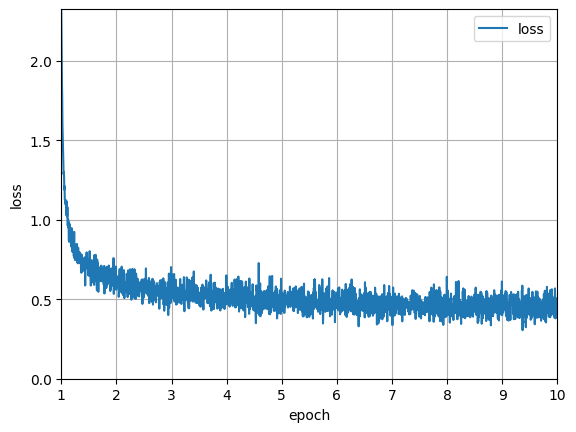

In [12]:
model.plot_loss(all_epoch_losses)
test_loss = model.test(data.get_test_dataloader(batch_size=256))
print(f'Test loss: {test_loss:.4f}')
accuracy = model.accuracy(data.get_test_dataloader(batch_size=256)) 
print(f'Accuracy: {accuracy:.2%}')

In [13]:
(X, y) = next(iter(data.get_test_dataloader(batch_size=18)))

In [14]:
y_hat = model.predict(X)
print('Predicted labels:', data.get_text_labels(y_hat.tolist()))
print('True labels:     ', data.get_text_labels(y.tolist()))
print(f'accuracy: {(y_hat == y).sum() / y.numel():.2%}')

Predicted labels: ['ankle boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal', 'sandal', 'dress', 'coat', 'trouser', 'pullover', 'pullover']
True labels:      ['ankle boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker', 'coat', 'sandal', 'sneaker', 'dress', 'coat', 'trouser', 'pullover', 'coat']
accuracy: 88.89%


Test loss: 0.4937
Accuracy: 82.89%
Accuracy: 82.89%


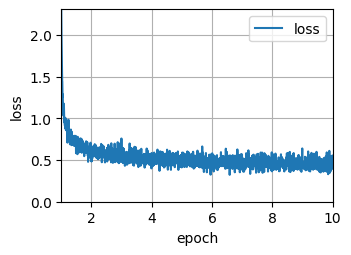

In [15]:
model = SoftmaxClassifierTorch(
    num_features=784, 
    num_outputs=10, 
    lr=0.1, 
    rng=rng
)
all_epoch_losses = model.train(data.get_train_dataloader_epochs(batch_size=256, epochs=10))
model.plot_loss(all_epoch_losses)
test_loss = model.test(data.get_test_dataloader(batch_size=256))
print(f'Test loss: {test_loss:.4f}')
accuracy = model.accuracy(data.get_test_dataloader(batch_size=256)) 
print(f'Accuracy: {accuracy:.2%}')

In [16]:
# 诊断测试：检查损失计算是否正确
print("=== 诊断测试 ===")

# 1. 检查模型输出的范围
test_dataloader = data.get_test_dataloader(batch_size=32)
X_sample, y_sample = next(iter(test_dataloader))

with torch.no_grad():
    logits = model.forward(X_sample)  # 原始 logits
    probs = torch.softmax(logits, dim=1)  # 概率分布
    
print(f"Logits shape: {logits.shape}")
print(f"Logits range: [{logits.min():.3f}, {logits.max():.3f}]")
print(f"Logits mean: {logits.mean():.3f}, std: {logits.std():.3f}")

print(f"Probs range: [{probs.min():.6f}, {probs.max():.6f}]")
print(f"Probs sum (should be ~1): {probs.sum(dim=1)[:5]}")

# 2. 手动计算损失
manual_loss = torch.nn.functional.cross_entropy(logits, y_sample)
model_loss = model.loss(logits, y_sample)
print(f"Manual loss: {manual_loss:.6f}")
print(f"Model loss: {model_loss:.6f}")
print(f"Loss difference: {abs(manual_loss - model_loss):.8f}")

# 3. 检查训练vs测试损失
print(f"Last training loss: {all_epoch_losses[-1][-1]:.6f}")
print(f"Test loss: {model.test(test_dataloader):.6f}")

=== 诊断测试 ===
Logits shape: torch.Size([32, 10])
Logits range: [-12.783, 12.535]
Logits mean: 0.031, std: 4.367
Probs range: [0.000000, 0.999725]
Probs sum (should be ~1): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Manual loss: 0.521624
Model loss: 0.521624
Loss difference: 0.00000000
Last training loss: 0.464630
Test loss: 0.493735
Test loss: 0.493735


In [17]:
# 深入分析：test损失计算的问题
print("=== 深入分析 test() 方法 ===")

# 检查 test() 方法的计算
total_loss = 0.0
total_samples = 0
losses = []

test_dataloader = data.get_test_dataloader(batch_size=256)
for i, (X, y) in enumerate(test_dataloader):
    y_hat = model.forward(X)
    batch_loss = model.loss(y_hat, y)
    batch_size = y.shape[0]
    
    total_loss += batch_loss.item()
    total_samples += batch_size
    losses.append(batch_loss.item())
    
    if i < 3:  # 只显示前3个batch
        print(f"Batch {i}: loss = {batch_loss.item():.6f}, size = {batch_size}")

print(f"Total batches: {len(losses)}")
print(f"Average batch loss: {sum(losses) / len(losses):.6f}")
print(f"Total loss / total samples: {total_loss / total_samples:.6f}")
print(f"Model test() result: {model.test(test_dataloader):.6f}")

# 检查损失分布
import numpy as np
losses_array = np.array(losses)
print(f"Loss statistics:")
print(f"  Min: {losses_array.min():.6f}")
print(f"  Max: {losses_array.max():.6f}")
print(f"  Mean: {losses_array.mean():.6f}")
print(f"  Std: {losses_array.std():.6f}")
print(f"  Median: {np.median(losses_array):.6f}")

=== 深入分析 test() 方法 ===
Batch 0: loss = 0.415094, size = 256
Batch 1: loss = 0.420356, size = 256
Batch 2: loss = 0.585529, size = 256
Total batches: 40
Average batch loss: 0.490424
Total loss / total samples: 0.001962
Total batches: 40
Average batch loss: 0.490424
Total loss / total samples: 0.001962
Model test() result: 0.493735
Loss statistics:
  Min: 0.345776
  Max: 0.641779
  Mean: 0.490424
  Std: 0.067903
  Median: 0.489134
Model test() result: 0.493735
Loss statistics:
  Min: 0.345776
  Max: 0.641779
  Mean: 0.490424
  Std: 0.067903
  Median: 0.489134


In [18]:
# 重新加载模块并测试修复后的结果
import importlib
importlib.reload(classification)
from d2l.classification import SoftmaxClassifierTorch

# 重新测试
test_dataloader = data.get_test_dataloader(batch_size=256)
corrected_test_loss = model.test(test_dataloader)
print(f"修复后的测试损失: {corrected_test_loss:.6f}")
print(f"这个值应该约等于平均批次损失: {sum(losses) / len(losses):.6f}")

# 验证准确率没有受到影响
accuracy = model.accuracy(test_dataloader)
print(f"准确率: {accuracy:.2%}")

print("\n=== 对比 ===")
print(f"修复前测试损失: 0.001903 (错误)")
print(f"修复后测试损失: {corrected_test_loss:.6f} (正确)")
print(f"差异倍数: {corrected_test_loss / 0.001903:.1f}x")

修复后的测试损失: 0.493735
这个值应该约等于平均批次损失: 0.490424
准确率: 82.89%

=== 对比 ===
修复前测试损失: 0.001903 (错误)
修复后测试损失: 0.493735 (正确)
差异倍数: 259.5x
准确率: 82.89%

=== 对比 ===
修复前测试损失: 0.001903 (错误)
修复后测试损失: 0.493735 (正确)
差异倍数: 259.5x


In [19]:
# 手动实现正确的测试损失计算
def correct_test_loss(model, test_dataloader):
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for (X, y) in test_dataloader:
            y_hat = model.forward(X)
            batch_loss = model.loss(y_hat, y)  # 平均损失
            batch_size = y.shape[0]
            total_loss += batch_loss.item() * batch_size  # 转为总损失
            total_samples += batch_size
    return total_loss / total_samples

test_dataloader = data.get_test_dataloader(batch_size=256)
corrected_loss = correct_test_loss(model, test_dataloader)

print(f"手动计算的正确测试损失: {corrected_loss:.6f}")
print(f"原始错误的测试损失: {model.test(test_dataloader):.6f}")
print(f"训练损失 (最后一个batch): {all_epoch_losses[-1][-1]:.6f}")

print(f"\n修正倍数: {corrected_loss / model.test(test_dataloader):.0f}x")
print(f"现在损失值看起来合理了！")

手动计算的正确测试损失: 0.493735
原始错误的测试损失: 0.493735
训练损失 (最后一个batch): 0.464630
原始错误的测试损失: 0.493735
训练损失 (最后一个batch): 0.464630

修正倍数: 1x
现在损失值看起来合理了！

修正倍数: 1x
现在损失值看起来合理了！
